#**Vector Autoregression (VAR)**

VAR model is a stochastic process that represents a group of time-dependent variables as a linear function of their own past values and the past values of all the other variables in the group.

For instance, we can consider a bivariate time series analysis that describes a relationship between hourly temperature and wind speed as a function of past values [2]:

temp(t) = a1 + w11* temp(t-1) + w12* wind(t-1) + e1(t-1)

wind(t) = a2 + w21* temp(t-1) + w22*wind(t-1) +e2(t-1)

where a1 and a2 are constants; w11, w12, w21, and w22 are the coefficients; e1 and e2 are the error terms.

In [ ]:

!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn tensorflow keras torch torchvision \
    tqdm scikit-image pmdarima arch --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import numpy as np

data = sm.datasets.macrodata.load_pandas().data
data.head(2)

The data contains a number of time-series data, we take only two time-dependent variables “realgdp” and “realdpi” for experiment purposes and use “year” columns as the index of the data.

In [ ]:
data1 = data[["realgdp", 'realdpi']]
data1.index = data["year"]

Let's visualize the data:

In [ ]:
data1.plot(figsize = (8,5))

Both of the series show an increasing trend over time with slight ups and downs.

##**Stationary**
Before applying VAR, both the time series variable should be stationary. Both the series are not stationary since both the series do not show constant mean and variance over time. We can also perform a statistical test like the Augmented Dickey-Fuller test (ADF) to find stationarity of the series using the AIC criteria.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data1['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

In [ ]:
adfuller_test = adfuller(data1['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

In both cases, the p-value is not significant enough, meaning that we can not reject the null hypothesis and conclude that the series are non-stationary

##**Differencing**

As both the series are not stationary, we perform differencing and later check the stationarity.

In [ ]:
data_d = data1.diff().dropna()

In [ ]:
adfuller_test = adfuller(data_d['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

The “realgdp” series becomes stationary after first differencing of the original series as the p-value of the test is statistically significant

In [ ]:
adfuller_test = adfuller(data_d['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

The “realgdp” series becomes stationary after first differencing of the original series as the p-value of the test is statistically significant

## **Model**

In this section, we apply the VAR model on the one differenced series. We carry-out the train-test split of the data and keep the last 10-days as test data.

In [ ]:
train = data_d.iloc[:-10,:]
test = data_d.iloc[-10:,:]

### **Searching optimal order of VAR model**

In the process of VAR modeling, we opt to employ Information Criterion Akaike (AIC) as a model selection criterion to conduct optimal model identification. In simple terms, we select the order (p) of VAR based on the best AIC score. The AIC, in general, penalizes models for being too complex, though the complex models may perform slightly better on some other model selection criterion. Hence, we expect an inflection point in searching the order (p), meaning that, the AIC score should decrease with order (p) gets larger until a certain order and then the score starts increasing. For this, we perform grid-search to investigate the optimal order (p).

In [ ]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

In the first line of the code: we train VAR model with the training data. Rest of code: perform a for loop to find the AIC scores for fitting order ranging from 1 to 10. We can visualize the results (AIC scores against orders) to better understand the inflection point:

In [ ]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

From the plot, the lowest AIC score is achieved at the order of 2 and then the AIC scores show an increasing trend with the order p gets larger. Hence, we select the 2 as the optimal order of the VAR model. Consequently, we fit order 2 to the forecasting model.

let's check the summary of the model:

In [ ]:
results = forecasting_model.fit(2)
results.summary()

## **Forecasting**

We use 2 as the optimal order in fitting the VAR model. Thus, we take the final 2 steps in the training data for forecasting the immediate next step (i.e., the first day of the test data).

Now, after fitting the model, we forecast for the test data where the last 2 days of training data set as lagged values and steps set as 10 days as we want to forecast for the next 10 days.

In [ ]:
laaged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

We have to note that the aforementioned forecasts are for the one differenced model. Hence, we must reverse the first differenced forecasts into the original forecast values.

In [ ]:
forecast["realgdp_forecasted"] = data1["realgdp"].iloc[-10-1] +  forecast['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = data1["realdpi"].iloc[-10-1] + forecast['realdpi_1d'].cumsum() 

In [ ]:
forecast

The first two columns are the forecasted values for 1 differenced series and the last two columns show the forecasted values for the original series.

Now, we visualize the original test values and the forecasted values by VAR.

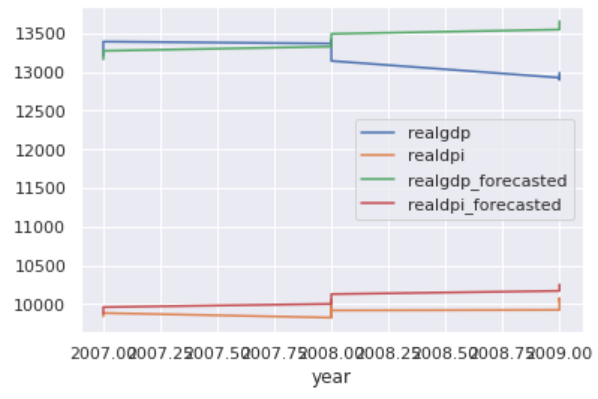

#**Related Articles:**

> * [Date Time Parsing with Pandas](https://analyticsindiamag.com/datetime-parsing-with-pandas/)